In [1]:
from wrapper_functions import *

2023-03-08 16:39:38.719806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which i

TensorFlow version: 2.10.0. Expected: 2.7.0
TensorFlow Probability version: 0.18.0. Expected: 0.15.0


2023-03-08 16:40:07.522488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Preparation and Parameters Setup

In [2]:
# use BAE as the 1st step
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=10 # @param
mcmc_burnin=2_500 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)


# BMA parameters.
y_noise_std = 0.01  # Note: Changed from 0.1 # @param
bma_gp_lengthscale = .55 # @param
bma_gp_l2_regularizer = .3 # @param

bma_n_samples_train = 100 # @param
bma_n_samples_eval = 250 # @param
bma_n_samples_test = 250 # @param
bma_seed = 0 # @param

# ### Read training/prediction data
training_eastMA = pd.read_csv('../data/training_dataset/training_eastMA.csv')
training_eastMA_noMI = training_eastMA[:51]
training_eastMA_folds = pd.read_csv('../data/training_dataset/training_eastMA_folds.csv')
base_model_predictions_eastMA = pd.read_csv('../data/prediction_dataset/base_model_predictions_eastMA.csv')

print("pred longitude max and min", base_model_predictions_eastMA["lon"].max(),base_model_predictions_eastMA["lon"].min())
print("pred latitude max and min", base_model_predictions_eastMA["lat"].max(),base_model_predictions_eastMA["lat"].min())
#list(base_model_predictions_eastMA.columns)
print("train longitude max and min", training_eastMA["lon"].max(),training_eastMA["lon"].min())
print("train latitude max and min", training_eastMA["lat"].max(),training_eastMA["lat"].min())


training51= pd.read_csv('../data/training_dataset/training51.csv')

# standardize
X_train1 = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
X_test1 = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
X_valid = np.concatenate((X_train1, X_test1), axis=0)
X_centr = np.mean(X_valid, axis=0)
X_scale = np.max(X_valid, axis=0) - np.min(X_valid, axis=0)

X_train1 = (X_train1 - X_centr) / X_scale
X_test1 = (X_test1 - X_centr) / X_scale

Y_train = np.expand_dims(training_eastMA_noMI["aqs"], 1).astype(np.float32)
#Y_test = np.expand_dims(base_model_predictions_eastMA["pred_av"], 1).astype(np.float32)

print("2011 center and scale: ", X_centr, X_scale)


base_model_names = ["pred_av", "pred_gs", "pred_caces"]
base_preds_train = tf.stack([training_eastMA_noMI[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
base_preds_test = tf.stack([base_model_predictions_eastMA[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)


# Assemble into configs.
bma_model_config = DEFAULT_GP_CONFIG.copy()
map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()

bma_model_config.update(dict(lengthscale=bma_gp_lengthscale,
                             l2_regularizer=bma_gp_l2_regularizer,
                             y_noise_std=y_noise_std,
                             #activation='relu',
                             activation_func='softmax'))
print(bma_model_config)

bma_config=dict(gp_lengthscale=bma_gp_lengthscale,
                gp_l2_regularizer=bma_gp_l2_regularizer,
                y_noise_std=y_noise_std,
                map_step_size=map_step_size,
                map_num_steps=map_num_steps,
                mcmc_step_size=mcmc_step_size,
                mcmc_num_steps=mcmc_num_steps,
                mcmc_initialize_from_map=False,
                n_samples_eval=bma_n_samples_eval,
                n_samples_train=bma_n_samples_train,
                n_samples_test=bma_n_samples_test,
                seed=bma_seed)
print(bma_config)



# BNE parameters.
bne_gp_lengthscale = 7.5  # 5. # @param
bne_gp_l2_regularizer = 10  # 15 # @param
bne_variance_prior_mean = -2.5  # @param
bne_skewness_prior_mean = -2.5  # @param
bne_seed = 0  # @param
bne_config = dict(gp_lengthscale=bne_gp_lengthscale,
                  gp_l2_regularizer=bne_gp_l2_regularizer,
                  variance_prior_mean=bne_variance_prior_mean,
                  skewness_prior_mean=bne_skewness_prior_mean,
                  map_step_size=map_step_size,
                  map_num_steps=map_num_steps,
                  mcmc_step_size=mcmc_step_size,
                  mcmc_num_steps=mcmc_num_steps,
                  mcmc_nchain=mcmc_nchain,
                  mcmc_burnin=mcmc_burnin,
                  mcmc_initialize_from_map=bne_mcmc_initialize_from_map,
                  seed=bne_seed)

print(bne_config)

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))

mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain,
                       debug_mode=False))



pred longitude max and min -69.93 -73.5
pred latitude max and min 44.3 40.6
train longitude max and min -70.023598 -73.443056
train latitude max and min 44.107524 40.74529
2011 center and scale:  [-72.185104  42.680347] [3.5699997 3.7000008]
{'lengthscale': 0.55, 'l2_regularizer': 0.3, 'hidden_units': 128, 'y_noise_std': 0.01, 'activation_func': 'softmax'}
{'gp_lengthscale': 0.55, 'gp_l2_regularizer': 0.3, 'y_noise_std': 0.01, 'map_step_size': 0.0005, 'map_num_steps': 10000, 'mcmc_step_size': 0.0001, 'mcmc_num_steps': 1000, 'mcmc_initialize_from_map': False, 'n_samples_eval': 250, 'n_samples_train': 100, 'n_samples_test': 250, 'seed': 0}
{'gp_lengthscale': 7.5, 'gp_l2_regularizer': 10, 'variance_prior_mean': -2.5, 'skewness_prior_mean': -2.5, 'map_step_size': 0.0005, 'map_num_steps': 10000, 'mcmc_step_size': 0.0001, 'mcmc_num_steps': 1000, 'mcmc_nchain': 10, 'mcmc_burnin': 2500, 'mcmc_initialize_from_map': True, 'seed': 0}


[ 0  1  3  4  5  6  7  8  9 12 13 14 15 16 17 18 19 20 21 23 24 25 26 27
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] [ 2 10 11 22 28 29]
(45, 2) (6, 2) (45, 1) (6, 1) (45, 3) (6, 3)
[[9.97563  ]
 [9.837391 ]
 [6.332692 ]
 [9.2525   ]
 [5.0865545]
 [8.473109 ]]
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.7530794143676758
activation function used softmax
activation function used softmax
activation function used softmax
[[10.141383 ]
 [ 9.808298 ]
 [ 6.4575377]
 [ 9.202971 ]
 [ 6.0986686]
 [ 9.171652 ]]
BMA:
Running MCMC:	Acceptance Ratio: 0.7705551981925964
[[10.125133 ]
 [ 9.729334 ]
 [ 6.505002 ]
 [ 9.155392 ]
 [ 5.9703245]
 [ 9.110973 ]]
BAE:
Running MAP:	157694.28125...65145.23828125...34818.4921875...20930.416015625...13702.8642578125...9749.41015625...7593.1015625...6476.98974609375...5962.4765625...5771.8857421875...Done.
Running MCMC:	Acceptance Ratio: 0.657882571220398
[[10.02548  ]
 [ 9.631155 ]
 [ 6.3951507]
 [ 9.051133 ]
 

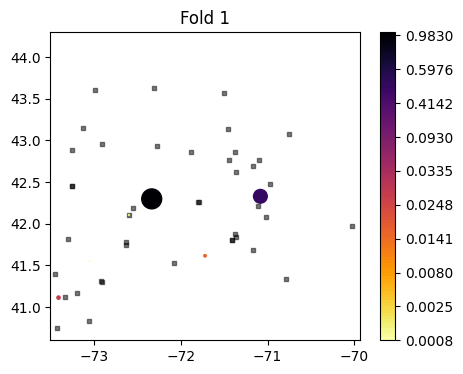

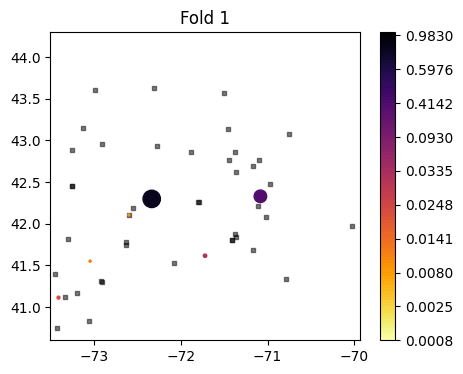

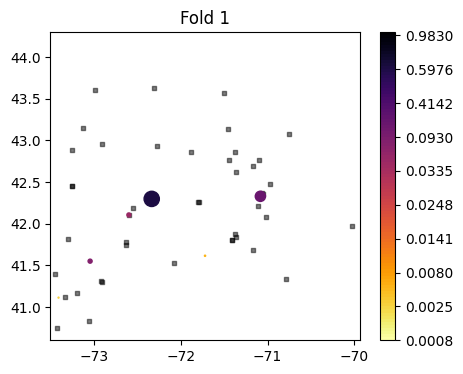

[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30 31 34 35 36 37 38 39 40 41 42 43 44 46 47 48 49 50] [ 4 26 32 33 45]
(46, 2) (5, 2) (46, 1) (5, 1) (46, 3) (5, 3)
[[9.969748]
 [8.599174]
 [8.657759]
 [9.079487]
 [6.503226]]
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.7574897408485413
activation function used softmax
activation function used softmax
activation function used softmax
[[9.580795 ]
 [8.752242 ]
 [9.35231  ]
 [8.837875 ]
 [7.1985545]]
BMA:
Running MCMC:	Acceptance Ratio: 0.8139399290084839
[[9.525076]
 [8.720247]
 [9.261722]
 [8.71865 ]
 [7.18416 ]]
BAE:
Running MAP:	209821.109375...88054.2421875...46889.9453125...27843.095703125...17794.689453125...12181.05859375...9013.587890625...7279.5888671875...6400.7333984375...6016.5224609375...Done.
Running MCMC:	Acceptance Ratio: 0.6561942100524902
[[9.417116]
 [8.603619]
 [9.142086]
 [8.608973]
 [7.055573]]
        lon       lat      diff
0 -0.342329 -0.42374

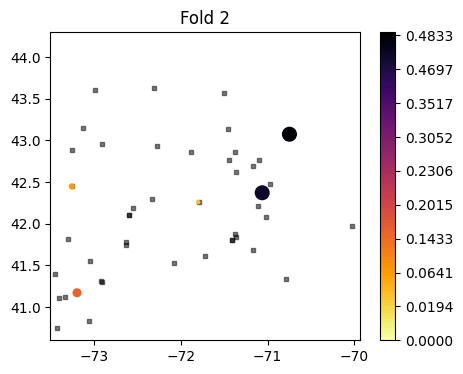

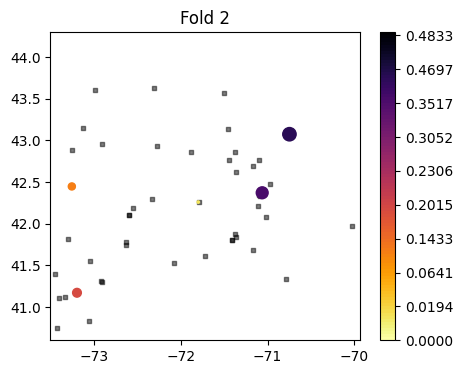

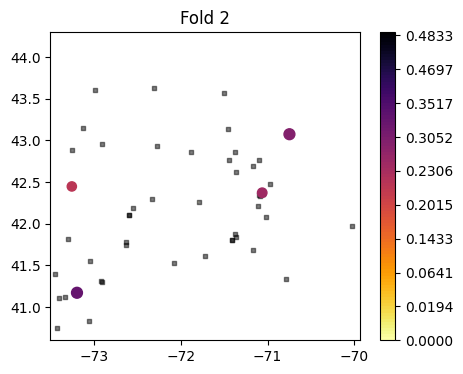

[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 28 29 30 31 32 33 36 37 38 39 40 42 43 44 45 46 47 48 49 50] [ 7 27 34 35 41]
(46, 2) (5, 2) (46, 1) (5, 1) (46, 3) (5, 3)
[[ 6.3469567]
 [ 9.01     ]
 [11.023407 ]
 [ 7.4215517]
 [ 6.447826 ]]
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.6615779995918274
activation function used softmax
activation function used softmax
activation function used softmax
[[7.8942695]
 [8.303245 ]
 [8.366608 ]
 [8.66652  ]
 [6.753341 ]]
BMA:
Running MCMC:	Acceptance Ratio: 0.7211170196533203
[[7.84528 ]
 [8.273523]
 [8.285954]
 [8.562851]
 [6.742785]]
BAE:
Running MAP:	106626.09375...44967.984375...24017.740234375...14568.69140625...9785.078125...7281.30078125...6007.93017578125...5420.4443359375...5198.36572265625...5140.60888671875...Done.
Running MCMC:	Acceptance Ratio: 0.7854233980178833
[[7.66252 ]
 [8.087835]
 [8.100317]
 [8.376203]
 [6.54458 ]]
        lon       lat      diff
0 -0.342329 

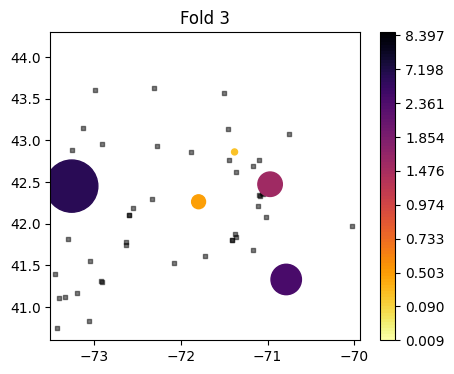

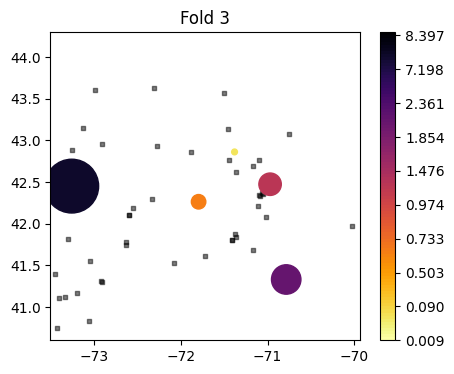

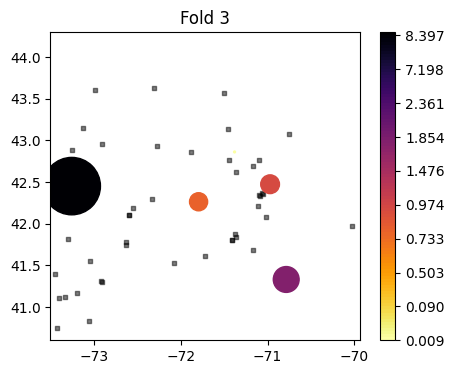

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 47 49 50] [14 18 42 46 48]
(46, 2) (5, 2) (46, 1) (5, 1) (46, 3) (5, 3)
[[8.803155]
 [8.728161]
 [7.062264]
 [8.909402]
 [5.991228]]
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.6183916926383972
activation function used softmax
activation function used softmax
activation function used softmax
[[9.490395 ]
 [8.864169 ]
 [6.74041  ]
 [7.5366163]
 [6.825264 ]]
BMA:
Running MCMC:	Acceptance Ratio: 0.8147476315498352
[[9.435921 ]
 [8.832998 ]
 [6.652049 ]
 [7.420287 ]
 [6.8112583]]
BAE:
Running MAP:	246649.921875...98468.125...52248.375...30897.892578125...19588.78515625...13206.8857421875...9549.3837890625...7501.55810546875...6429.0126953125...5934.70947265625...Done.
Running MCMC:	Acceptance Ratio: 0.6609712839126587
[[9.301277 ]
 [8.6912155]
 [6.5176854]
 [7.271626 ]
 [6.6529098]]
        lon       lat      diff
0 -0.342329 -0

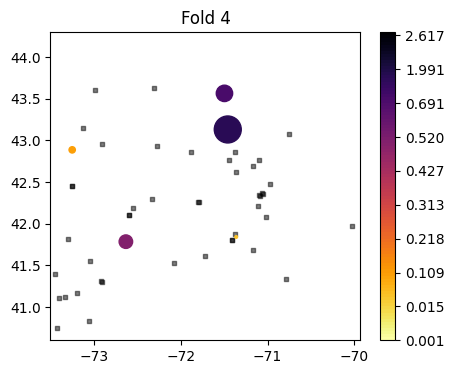

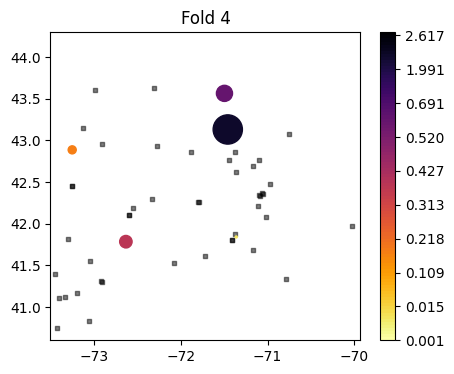

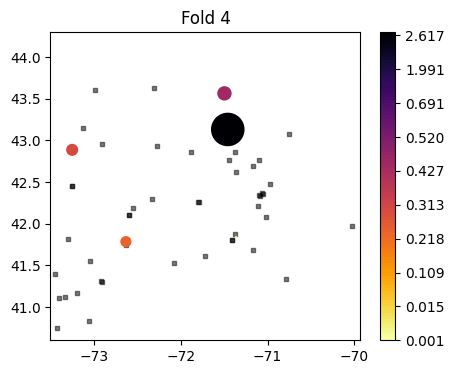

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17 18 19 20 21 22 23 24 25
 26 27 28 29 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47 48 49 50] [15 16 30 31 43]
(46, 2) (5, 2) (46, 1) (5, 1) (46, 3) (5, 3)
[[ 8.640988]
 [ 8.654546]
 [ 9.376471]
 [10.250689]
 [ 8.898305]]
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.6674602627754211
activation function used softmax
activation function used softmax
activation function used softmax
[[8.90076 ]
 [8.901332]
 [9.046666]
 [8.585136]
 [8.421533]]
BMA:
Running MCMC:	Acceptance Ratio: 0.8142477869987488
[[8.845397 ]
 [8.8695345]
 [8.956658 ]
 [8.466688 ]
 [8.407229 ]]
BAE:
Running MAP:	394724.3125...147625.453125...78263.015625...45924.92578125...28630.240234375...18710.419921875...12858.3662109375...9418.689453125...7464.70068359375...6432.94775390625...Done.
Running MCMC:	Acceptance Ratio: 0.663439929485321
[[8.643009]
 [8.668998]
 [8.751633]
 [8.262488]
 [8.202836]]
        lon       lat      diff
0 -0.342329 -0.4

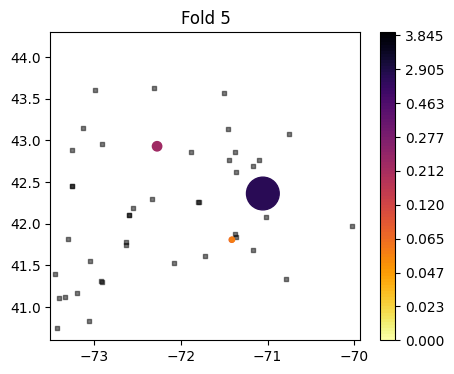

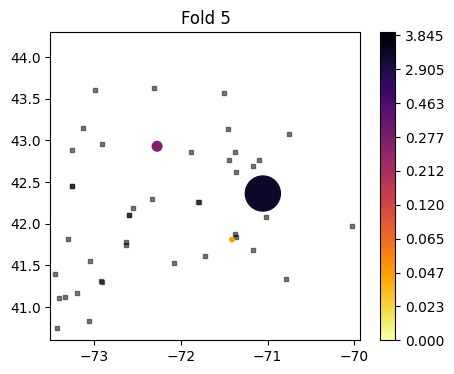

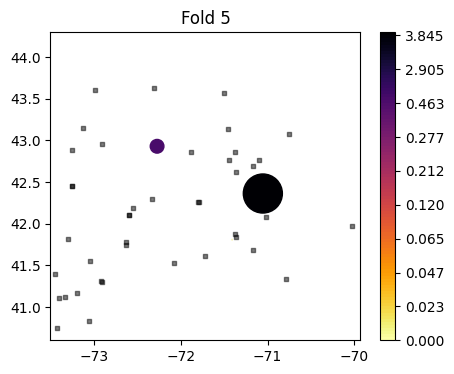

[ 0  1  2  3  4  5  6  7  9 10 11 12 14 15 16 17 18 19 21 22 23 24 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49] [ 8 13 20 25 50]
(46, 2) (5, 2) (46, 1) (5, 1) (46, 3) (5, 3)
[[9.52807  ]
 [9.362832 ]
 [5.460345 ]
 [7.4618163]
 [6.636667 ]]
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.7112334966659546
activation function used softmax
activation function used softmax
activation function used softmax
[[9.494084 ]
 [9.295187 ]
 [5.5064383]
 [7.911026 ]
 [8.335051 ]]
BMA:
Running MCMC:	Acceptance Ratio: 0.8170527219772339
[[9.440522 ]
 [9.264458 ]
 [5.4195347]
 [7.796583 ]
 [8.321601 ]]
BAE:
Running MAP:	181072.265625...76928.578125...40994.52734375...24385.365234375...15668.5068359375...10844.0390625...8161.978515625...6728.27685546875...6030.0400390625...5745.2021484375...Done.
Running MCMC:	Acceptance Ratio: 0.6700208783149719
[[9.330696 ]
 [9.1504   ]
 [5.2898016]
 [7.673419 ]
 [8.195544 ]]
        lon       lat      diff
0 -0

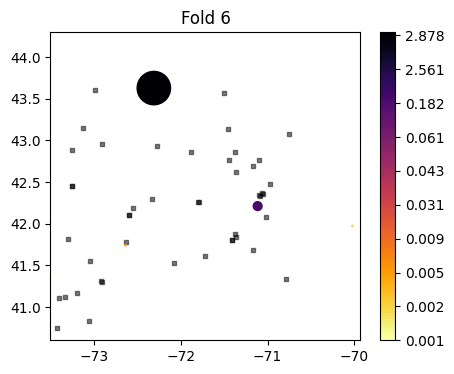

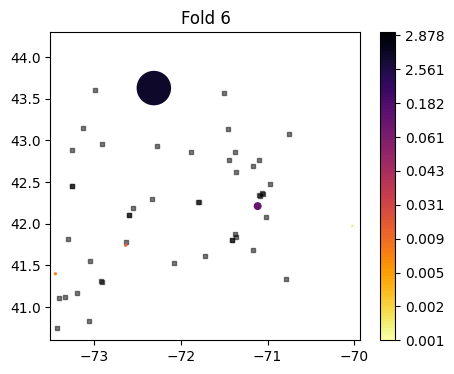

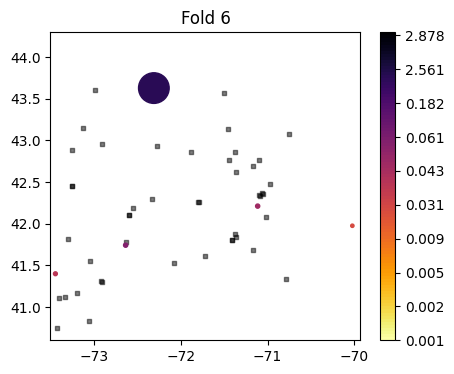

[ 0  2  3  4  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 38 39 41 42 43 44 45 46 47 48 49 50] [ 1  5 17 37 40]
(46, 2) (5, 2) (46, 1) (5, 1) (46, 3) (5, 3)
[[ 8.396441]
 [10.035838]
 [ 5.682759]
 [ 8.189075]
 [ 4.919658]]
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.7724781632423401
activation function used softmax
activation function used softmax
activation function used softmax
[[9.989731 ]
 [9.625831 ]
 [6.5106516]
 [8.748166 ]
 [5.7249603]]
BMA:
Running MCMC:	Acceptance Ratio: 0.8172471523284912
[[9.936379 ]
 [9.595226 ]
 [6.424084 ]
 [8.634173 ]
 [5.7115607]]
BAE:
Running MAP:	299123.96875...127214.8515625...67655.1484375...39777.28125...24847.501953125...16324.1845703125...11352.8212890625...8485.73046875...6904.22509765625...6106.2705078125...Done.
Running MCMC:	Acceptance Ratio: 0.7408887147903442
[[9.832376]
 [9.49023 ]
 [6.32104 ]
 [8.514386]
 [5.588204]]
        lon       lat      diff
0 -0.342329

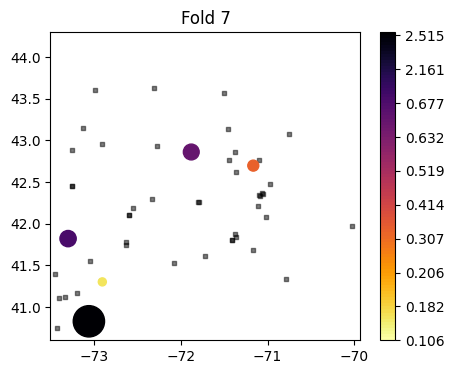

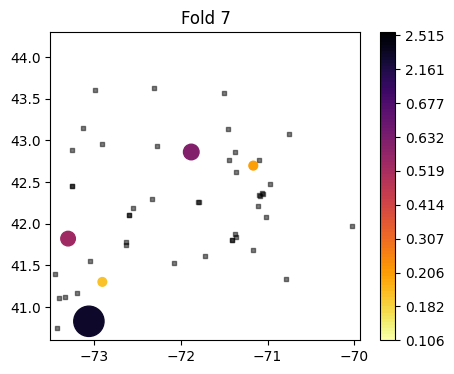

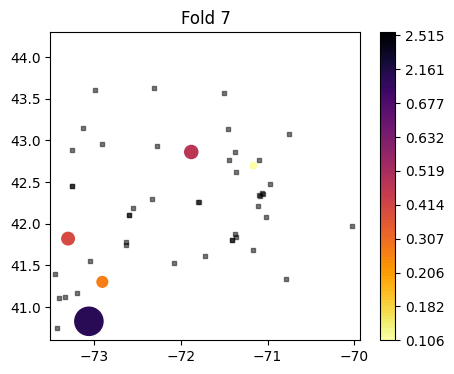

[ 0  1  2  3  4  5  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 25 26 27
 28 29 30 31 32 33 34 35 36 37 39 40 41 42 43 44 45 46 47 48 49 50] [ 6 12 23 24 38]
(46, 2) (5, 2) (46, 1) (5, 1) (46, 3) (5, 3)
[[10.041177 ]
 [ 7.8931036]
 [ 9.7575   ]
 [ 7.8369746]
 [ 7.4827585]]
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.5589591860771179
activation function used softmax
activation function used softmax
activation function used softmax
[[9.966008]
 [8.244575]
 [9.032518]
 [8.72381 ]
 [8.235121]]
BMA:
Running MCMC:	Acceptance Ratio: 0.8173488974571228
[[9.912938]
 [8.21414 ]
 [8.946213]
 [8.610274]
 [8.221743]]
BAE:
Running MAP:	188698.03125...77057.8203125...40978.234375...24388.34765625...15678.89453125...10845.6611328125...8150.37255859375...6706.07275390625...6001.6005859375...5713.740234375...Done.
Running MCMC:	Acceptance Ratio: 0.7580281496047974
[[9.811024 ]
 [8.098106 ]
 [8.840898 ]
 [8.506586 ]
 [8.0990305]]
        lon       lat      diff
0 -0.34232

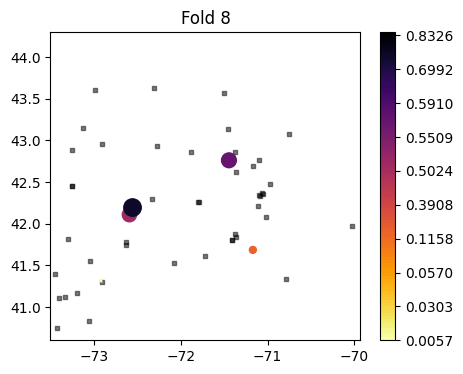

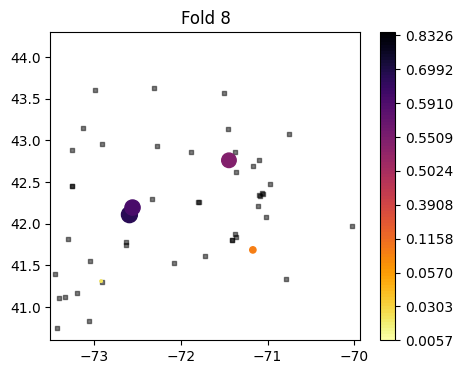

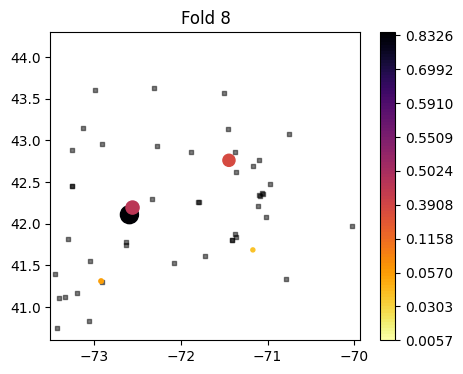

[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 20 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 37 38 40 41 42 43 44 45 46 47 48 49 50] [ 9 19 21 36 39]
(46, 2) (5, 2) (46, 1) (5, 1) (46, 3) (5, 3)
[[9.035897 ]
 [9.955856 ]
 [8.191735 ]
 [7.5737705]
 [7.5904346]]
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.7928187847137451
activation function used softmax
activation function used softmax
activation function used softmax
[[8.549367 ]
 [9.060149 ]
 [8.797884 ]
 [8.113021 ]
 [8.4650545]]
BMA:
Running MCMC:	Acceptance Ratio: 0.8143106698989868
[[8.494418]
 [9.028714]
 [8.708753]
 [7.995656]
 [8.450928]]
BAE:
Running MAP:	345454.5...127340.8359375...67646.8046875...39780.86328125...24899.541015625...16410.009765625...11453.11328125...8586.90625...7000.42236328125...6197.89013671875...Done.
Running MCMC:	Acceptance Ratio: 0.6617341637611389
[[8.326683]
 [8.857325]
 [8.534641]
 [7.823683]
 [8.269   ]]
        lon       lat      diff
0 -0.342329 -0.423743 

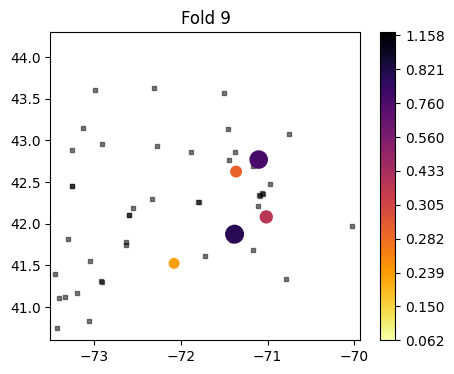

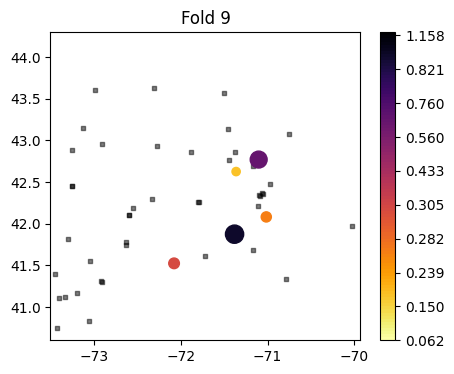

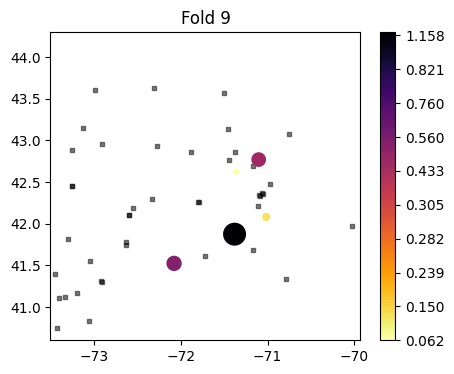

[ 1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 48 50] [ 0  3 44 47 49]
(46, 2) (5, 2) (46, 1) (5, 1) (46, 3) (5, 3)
[[ 8.835652 ]
 [ 9.485    ]
 [ 1.58     ]
 [ 3.8864079]
 [10.387156 ]]
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.6113154292106628
activation function used softmax
activation function used softmax
activation function used softmax
[[9.1999235]
 [8.920615 ]
 [5.113623 ]
 [5.9893584]
 [9.105335 ]]
BMA:
Running MCMC:	Acceptance Ratio: 0.828659176826477
[[9.15855  ]
 [8.896608 ]
 [5.0456095]
 [5.899762 ]
 [9.094683 ]]
BAE:
Running MAP:	131413.609375...54137.44140625...28559.884765625...16887.53515625...10838.42578125...7566.7451171875...5822.81640625...4957.1474609375...4586.6806640625...4466.568359375...Done.
Running MCMC:	Acceptance Ratio: 0.7526611685752869
[[9.087835 ]
 [8.822663 ]
 [4.9577045]
 [5.8168426]
 [9.002041 ]]
        lon       lat      diff
0

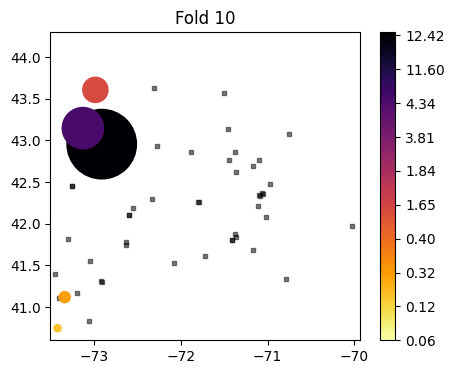

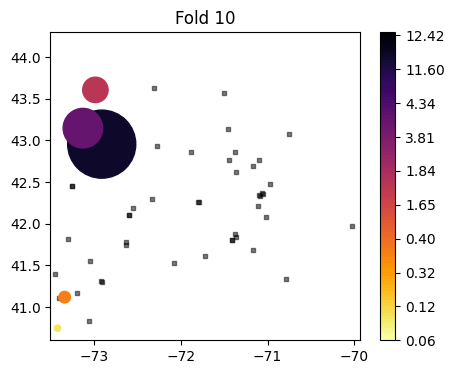

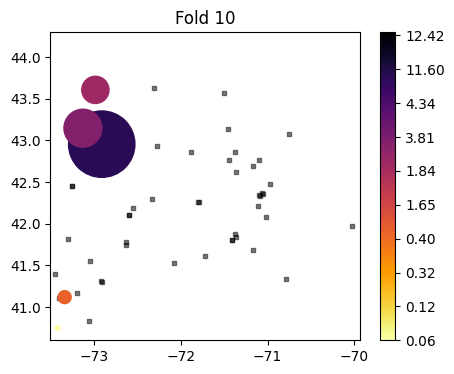

In [78]:

bae_bma_diff_line = []
bae_bma_diff_df = pd.DataFrame(columns=['lon', 'lat', 'diff'])
nll_lr_each, nll_gam_each, nll_bma_mean_each, nll_bma_each, nll_bae_each = [], [], [], [], []

fold_num = 0
kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True)
# rmse_bma_mean, rmse_bma2, rmse_bae = [], [], []
for train_index, test_index in kf.split(X_train1):
    fold_num += 1
    #print("Train:", train_index, "Validation:",test_index)
    X_tr, X_te = X_train1[train_index], X_train1[test_index]
    Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

    base_preds_tr, base_preds_te = base_preds_train.numpy(
    )[train_index], base_preds_train.numpy()[test_index]
    print(train_index, test_index)
    print(X_tr.shape, X_te.shape, Y_tr.shape, Y_te.shape,
          base_preds_tr.shape, base_preds_te.shape)
       
    # Create data dictionary.
    data_dicts = dict(X_train=X_tr,
                      X_test=X_te,
                      Y_train=Y_tr,
                      base_preds_train=base_preds_tr,
                      base_preds_test=base_preds_te)

    print(Y_te)
    # BMA-mean.
    print('BMA-mean:', flush=True)
    data_dict, bma_mean_joint_samples = get_bma_result(
        data_dicts, bma_config=bma_config)
    y_pred_bma_mean = np.mean(np.nan_to_num(
        bma_mean_joint_samples['y']), axis=0)
    print(y_pred_bma_mean)
    pred_var_bma_mean = calc_prediction_std(y_pred_bma_mean, Y_te)
    nll_bma_mean_each = (y_pred_bma_mean - Y_te)**2

    # BMA.
    print('BMA:', flush=True)
    bma_var_config = bne_config.copy()
    bma_var_config['mcmc_initialize_from_map'] = bma_config['mcmc_initialize_from_map']
    bma_joint_samples = get_bne_result(data_dict, moment_mode='none',
                                       bne_config=bma_var_config)
    y_pred_bma = np.mean(np.nan_to_num(bma_joint_samples['y']), axis=0)
    print(y_pred_bma)
    pred_var_bma = calc_prediction_std(y_pred_bma, Y_te)
    nll_bma_each = (y_pred_bma - Y_te)**2

    # BAE.
    print('BAE:', flush=True)
    bae_joint_samples = get_bne_result(data_dict, moment_mode='mean',
                                       bne_config=bne_config)
    y_pred_bae = np.mean(np.nan_to_num(bae_joint_samples['y']), axis=0)
    print(y_pred_bae)
    pred_var_bae = calc_prediction_std(y_pred_bae, Y_te)
    nll_bae_each = (y_pred_bae - Y_te)**2


    bae_bma_diff = pd.DataFrame(columns=['lon', 'lat', 'diff'])
    bae_bma_diff["lon"] = X_te[:, 0]
    bae_bma_diff["lat"] = X_te[:, 1]
    bae_bma_diff["diff"] = nll_bae_each - nll_bma_mean_each
    bae_bma_diff_df = bae_bma_diff_df.append(bae_bma_diff)

    print(bae_bma_diff_df)
    bae_bma_diff_line.append((pred_var_bae**2 - pred_var_bma_mean**2))
    # larger points are more error
    coordinate = np.asarray(base_model_predictions_eastMA[[
                        "lon", "lat"]].values.tolist()).astype(np.float32)

    nll_list = [nll_bma_mean_each, nll_bma_each, nll_bae_each]
    nll_list = np.asarray(nll_list)
    nll_list = nll_list.reshape(-1, len(nll_bma_mean_each)*3)

    color_norm_nll_each = make_color_norm(
        nll_list.reshape(len(nll_list), -1),method='percentile')

    # plot the bae_bma_diff_df
    plt.figure(figsize=(5, 4))
    plt.scatter(X_tr[:, 0] * X_scale[0] + X_centr[0], X_tr[:, 1] * X_scale[1] +
            X_centr[1], c="black", s=10, alpha=0.5, marker="s")  # different shape
    plt.scatter(X_te[:, 0] * X_scale[0] + X_centr[0], X_te[:, 1] * X_scale[1] + X_centr[1], c=nll_bma_mean_each,
                s=abs(nll_bma_mean_each)*200, cmap='inferno_r', norm=color_norm_nll_each)

    cbar = plt.colorbar()

    plt.title("Fold " + str(fold_num))

    plt.xlim(min(coordinate[:, 0]), max(coordinate[:, 0]))
    plt.ylim(min(coordinate[:, 1]), max(coordinate[:, 1]))
    plt.show()

    # plot the bae_bma_diff_df
    plt.figure(figsize=(5, 4))
    plt.scatter(X_tr[:, 0] * X_scale[0] + X_centr[0], X_tr[:, 1] * X_scale[1] +
                X_centr[1], c="black", s=10, alpha=0.5, marker="s")  # different shape
    plt.scatter(X_te[:, 0] * X_scale[0] + X_centr[0], X_te[:, 1] * X_scale[1] + X_centr[1], c=nll_bma_each,
                s=abs(nll_bma_each)*200, cmap='inferno_r', norm=color_norm_nll_each)

    cbar = plt.colorbar()

    plt.title("Fold " + str(fold_num))

    plt.xlim(min(coordinate[:, 0]), max(coordinate[:, 0]))
    plt.ylim(min(coordinate[:, 1]), max(coordinate[:, 1]))
    plt.show()

    # plot the bae_bma_diff_df
    plt.figure(figsize=(5, 4))
    plt.scatter(X_tr[:, 0] * X_scale[0] + X_centr[0], X_tr[:, 1] * X_scale[1] +
            X_centr[1], c="black", s=10, alpha=0.5, marker="s")  # different shape
    plt.scatter(X_te[:, 0] * X_scale[0] + X_centr[0], X_te[:, 1] * X_scale[1] + X_centr[1], c=nll_bae_each,
                s=abs(nll_bae_each)*200, cmap='inferno_r', norm=color_norm_nll_each)

    cbar = plt.colorbar()

    plt.title("Fold " + str(fold_num))

    plt.xlim(min(coordinate[:, 0]), max(coordinate[:, 0]))
    plt.ylim(min(coordinate[:, 1]), max(coordinate[:, 1]))
    plt.show()  

#print(bae_bma_diff_line)


In [64]:
#change bae_bma_diff_line to numpy array
bae_bma_diff_line = np.asarray(bae_bma_diff_line)
print(bae_bma_diff_line)


[-0.02927293  0.00847873  0.00694466  0.06685483  0.04847932  0.02148712
 -0.00676852  0.00395033 -0.02202654 -0.11568356]


In [79]:
nll_bma_mean_each


array([[ 0.13269348],
       [ 0.3185298 ],
       [12.486493  ],
       [ 4.422401  ],
       [ 1.6430633 ]], dtype=float32)

In [ ]:
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri, r
import rpy2.robjects as ro
import pandas as pd
from rpy2.robjects.packages import importr
from rpy2 import robjects as ro
import rpy2
kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True)

rmse_lr = []
rmse_gam = []
rmse_bma = []
rmse_bae = []
rmse_bma2 = []
rmse_bma_mean = []


nll_lr, nll_gam, nll_bma_mean, nll_bma, nll_bae = [], [], [], [], []
nll_bma2 = []
# initialize a dataframe to store lon, lat and raw error
error_df = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])

coverage_lr, coverage_gam, coverage_bma_mean, coverage_bma, coverage_bae = 0, 0, 0, 0, 0
coverage_bma2 = 0
#from rpy2.robjects import pandas2ri
# import R's "base" package
base = importr('base')
#ms = importr('MSGARCH')
# import R's "utils" package
utils = importr('utils')

with localconverter(ro.default_converter + pandas2ri.converter):
  # convert "lon" and "lat" in training_eastMA_noMI into scaled X_train1 values
  training_eastMA_noMI["lon"] = (
      training_eastMA_noMI["lon"] - X_centr[0]) / X_scale[0]
  training_eastMA_noMI["lat"] = (
      training_eastMA_noMI["lat"] - X_centr[1]) / X_scale[1]
  r_from_pd_df = ro.conversion.py2rpy(training_eastMA_noMI)


mgcv = importr('mgcv')
stats = importr('stats')
ciTools = importr('ciTools')


kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True)
rmse_bma_mean, rmse_bma2, rmse_bae = [], [], []
for train_index, test_index in kf.split(X_train1):
    #print("Train:", train_index, "Validation:",test_index)
    X_tr, X_te = X_train1[train_index], X_train1[test_index]
    Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

    base_preds_tr, base_preds_te = base_preds_train.numpy(
    )[train_index], base_preds_train.numpy()[test_index]
    print(train_index, test_index)
    print(X_tr.shape, X_te.shape, Y_tr.shape, Y_te.shape,
          base_preds_tr.shape, base_preds_te.shape)

    r_dat_py = training_eastMA_noMI

    with localconverter(ro.default_converter + pandas2ri.converter):
        r_tr = ro.conversion.py2rpy(r_dat_py.iloc[train_index])
        r_te = ro.conversion.py2rpy(r_dat_py.iloc[test_index])

    # Ref: lr
    lr_model = stats.lm(ro.Formula(
        'aqs~pred_av+pred_gs+pred_caces'), data=r_tr)
    l = ciTools.add_pi(r_te, lr_model)
    lr_pred = l[7]
    lr_ci_l, lr_ci_u = l[8], l[9]
    coverage_lr += np.sum([(Y_te[i] > lr_ci_l[i]) &
                          (Y_te[i] < lr_ci_u[i]) for i in range(len(Y_te))])
    rmse_lr.append(rmse(Y_te, np.asanyarray(lr_pred).reshape(-1, 1)))
    nll_lr.append(nll(Y_te, np.asanyarray(lr_pred).reshape(-1, 1)))
    print(rmse_lr)

    # Ref: GAM
    #df = training_eastMA_noMI.iloc[train_index]
    gam_model = mgcv.gam(ro.Formula(
        'aqs ~ s(lon, lat, by=pred_av, k=4) + s(lon, lat,by=pred_gs, k=4) +s(lon, lat, by=pred_caces, k=4)'), data=r_tr)
    a = ciTools.add_pi(r_te, gam_model)
    gam_pred = a[7]
    gam_ci_l, gam_ci_u = a[8], a[9]
    coverage_gam += np.sum([(Y_te[i] > gam_ci_l[i]) &
                           (Y_te[i] < gam_ci_u[i]) for i in range(len(Y_te))])
    rmse_gam.append(rmse(Y_te, np.asanyarray(gam_pred).reshape(-1, 1)))
    nll_gam.append(nll(Y_te, np.asanyarray(gam_pred).reshape(-1, 1)))
    print(rmse_gam)

    bma_prior, bma_gp_config = bma_dist(X_tr,
                                        base_preds_tr,
                                        **bma_model_config)

    bma_model_config.update(bma_gp_config)

    bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior,
                                               model_config=bma_model_config,
                                               Y=Y_tr,
                                               map_config=map_config,
                                               mcmc_config=mcmc_config)

        #fixed_input_te = tf.ones((X_te.shape[0], 2), dtype=tf.float32)
    bma_joint_samples = make_bma_samples(X_te, None, base_preds_te,
                                         bma_weight_samples=bma_gp_w_samples[0],
                                         bma_model_config=bma_model_config,
                                         n_samples=bma_n_samples_eval,
                                         seed=bne_seed,
                                         y_samples_only=False)
    y_pred = bma_joint_samples['y']
    y_pred = tf.reduce_mean(y_pred, axis=0)
    
    print("BMA prediction", y_pred.numpy().T)
    print("LR prediction", lr_pred)
    print("GAM prediction", gam_pred)
    pred_std = calc_prediction_std(y_pred, Y_te)
    print("pred_std", pred_std)
    pred_mean = tf.reduce_mean(y_pred, axis=1)
    print("pred_mean",pred_mean)
    bma_pi = np.array([(pred_mean - 1.96*pred_std).numpy(),
                      (pred_mean + 1.96*pred_std).numpy()])
    print(bma_pi)
    rmse_bma.append(rmse(Y_te, y_pred))
    nll_bma2.append(nll(Y_te, y_pred))
    coverage_bma2 += np.sum([(Y_te[i] > bma_pi[0][i]) & (Y_te[i] < bma_pi[1][i]) for i in range(len(Y_te))])
                            
    # Create data dictionary.
    data_dicts = dict(X_train=X_tr,
                      X_test=X_te,
                      Y_train=Y_tr,
                      base_preds_train=base_preds_tr,
                      base_preds_test=base_preds_te)

    print(Y_te)
    # BMA-mean.
    print('BMA-mean:', flush=True)
    data_dict, bma_mean_joint_samples = get_bma_result(
        data_dicts, bma_config=bma_config)
    y_pred_bma_mean = np.mean(np.nan_to_num(
        bma_mean_joint_samples['y']), axis=0)
    pred_std = calc_prediction_std(y_pred_bma_mean, Y_te)
    bma_mean_pi = np.array([(y_pred_bma_mean - 1.96*pred_std).numpy(), (y_pred_bma_mean + 1.96*pred_std).numpy()])
    print(y_pred_bma_mean)

    # BMA.
    bma_var_config = bne_config.copy()
    bma_var_config['mcmc_initialize_from_map'] = bma_config['mcmc_initialize_from_map']
    bma_joint_samples = get_bne_result(data_dict, moment_mode='none',
                                       bne_config=bma_var_config)
    y_pred_bma = np.mean(np.nan_to_num(bma_joint_samples['y']), axis=0)
    print(y_pred_bma)
    pred_std = calc_prediction_std(y_pred_bma, Y_te)
    bma_pi2 = np.array([(y_pred_bma - 1.96*pred_std).numpy(), (y_pred_bma + 1.96*pred_std).numpy()])

    # BAE.
    bae_joint_samples = get_bne_result(data_dict, moment_mode='mean',
                                       bne_config=bne_config)
    y_pred_bae = np.mean(np.nan_to_num(bae_joint_samples['y']), axis=0)
    print(y_pred_bae)
    pred_std = calc_prediction_std(y_pred_bae, Y_te)
    bae_pi = np.array([(y_pred_bae - 1.96*pred_std).numpy(), (y_pred_bae + 1.96*pred_std).numpy()])
    
    # save the rmse & nll for each fold
    rmse_bma_mean.append(rmse(Y_te, y_pred_bma_mean))
    nll_bma_mean.append(nll(Y_te, y_pred_bma_mean))
    rmse_bma2.append(rmse(Y_te, y_pred_bma))
    nll_bma.append(nll(Y_te, y_pred_bma))
    rmse_bae.append(rmse(Y_te, y_pred_bae))
    nll_bae.append(nll(Y_te, y_pred_bae))
   
    # save the coverage for each fold
    coverage_bma_mean += np.sum([(Y_te[i] > bma_mean_pi[0][i]) & (Y_te[i] < bma_mean_pi[1][i]) for i in range(len(Y_te))])
    coverage_bma += np.sum([(Y_te[i] > bma_pi2[0][i]) & (Y_te[i] < bma_pi2[1][i]) for i in range(len(Y_te))])
    coverage_bae += np.sum([(Y_te[i] > bae_pi[0][i]) & (Y_te[i] < bae_pi[1][i]) for i in range(len(Y_te))])
    
    raw_error = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])
    raw_error["lon"] = X_te[:,0]
    raw_error["lat"] = X_te[:,1]
    raw_error["raw_error"] = (y_pred_bae - Y_te).reshape(-1)
    error_df = error_df.append(raw_error)
    print("rmse:", flush=True)
    print(rmse_bma_mean, rmse_bma2, rmse_bae)
    print("nll:", flush=True)
    print(nll_bma_mean, nll_bma, nll_bae)


In [ ]:

print("RMSE LR: ", np.mean(rmse_lr), np.median(rmse_lr), np.std(rmse_lr))
print("RMSE GAM: ", np.mean(rmse_gam), np.median(rmse_gam), np.std(rmse_gam))
print("RMSE BMA: ", np.mean(rmse_bma2), np.median(rmse_bma2), np.std(rmse_bma2))
print("RMSE BMA-Mean: ", np.mean(rmse_bma_mean), np.median(rmse_bma_mean), np.std(rmse_bma_mean))
print("RMSE BMA:", np.mean(rmse_bma), np.median(rmse_bma), np.std(rmse_bma))
print("RMSE BAE: ", np.mean(rmse_bae), np.median(rmse_bae), np.std(rmse_bae))

print("RMSE BMA-Mean: ", rmse_bma_mean)
print("RMSE BMA:", rmse_bma)
print("RMSE BAE: ", rmse_bae)


### check cross-validation NLL at each location (y_true-y_pred)^2/pred_var

In [4]:
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri, r
import rpy2.robjects as ro
import pandas as pd
from rpy2.robjects.packages import importr
from rpy2 import robjects as ro
import rpy2
kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True)

nll_lr_each, nll_gam_each, nll_bma_mean_each, nll_bma_each, nll_bae_each = [], [], [], [], []
nll_bma2_each = []
# initialize a dataframe to store lon, lat and raw error
error_df = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])

coverage_lr, coverage_gam, coverage_bma_mean, coverage_bma, coverage_bae = 0, 0, 0, 0, 0
coverage_bma2 = 0
#from rpy2.robjects import pandas2ri
# import R's "base" package
base = importr('base')
#ms = importr('MSGARCH')
# import R's "utils" package
utils = importr('utils')

with localconverter(ro.default_converter + pandas2ri.converter):
  # convert "lon" and "lat" in training_eastMA_noMI into scaled X_train1 values
  training_eastMA_noMI["lon"] = (
      training_eastMA_noMI["lon"] - X_centr[0]) / X_scale[0]
  training_eastMA_noMI["lat"] = (
      training_eastMA_noMI["lat"] - X_centr[1]) / X_scale[1]
  r_from_pd_df = ro.conversion.py2rpy(training_eastMA_noMI)


mgcv = importr('mgcv')
stats = importr('stats')
ciTools = importr('ciTools')

kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True)
rmse_bma_mean, rmse_bma2, rmse_bae = [], [], []
for train_index, test_index in kf.split(X_train1):
    #print("Train:", train_index, "Validation:",test_index)
    X_tr, X_te = X_train1[train_index], X_train1[test_index]
    Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

    base_preds_tr, base_preds_te = base_preds_train.numpy(
    )[train_index], base_preds_train.numpy()[test_index]
    print(train_index, test_index)
    print(X_tr.shape, X_te.shape, Y_tr.shape, Y_te.shape,
          base_preds_tr.shape, base_preds_te.shape)

    r_dat_py = training_eastMA_noMI

    with localconverter(ro.default_converter + pandas2ri.converter):
        r_tr = ro.conversion.py2rpy(r_dat_py.iloc[train_index])
        r_te = ro.conversion.py2rpy(r_dat_py.iloc[test_index])

    # Ref: lr
    lr_model = stats.lm(ro.Formula(
        'aqs~pred_av+pred_gs+pred_caces'), data=r_tr)
    l = ciTools.add_pi(r_te, lr_model)
    lr_pred = l[7]
    lr_ci_l, lr_ci_u = l[8], l[9]
    nll_lr_each = np.append(nll_lr_each, nll_each(Y_te.T, lr_pred).numpy())
    

    # Ref: GAM
    #df = training_eastMA_noMI.iloc[train_index]
    gam_model = mgcv.gam(ro.Formula(
        'aqs ~ s(lon, lat, by=pred_av, k=4) + s(lon, lat,by=pred_gs, k=4) +s(lon, lat, by=pred_caces, k=4)'), data=r_tr)
    a = ciTools.add_pi(r_te, gam_model)
    gam_pred = a[7]
    gam_ci_l, gam_ci_u = a[8], a[9]
    nll_gam_each = np.append(nll_gam_each, nll_each(Y_te.T, gam_pred).numpy())

    bma_prior, bma_gp_config = bma_dist(X_tr,
                                        base_preds_tr,
                                        **bma_model_config)

    bma_model_config.update(bma_gp_config)

    bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior,
                                               model_config=bma_model_config,
                                               Y=Y_tr,
                                               map_config=map_config,
                                               mcmc_config=mcmc_config)

    bma_joint_samples = make_bma_samples(X_te, None, base_preds_te,
                                         bma_weight_samples=bma_gp_w_samples[0],
                                         bma_model_config=bma_model_config,
                                         n_samples=bma_n_samples_eval,
                                         seed=bne_seed,
                                         y_samples_only=False)
    y_pred = bma_joint_samples['y']
    y_pred = tf.reduce_mean(y_pred, axis=0)
    nll_bma2_each = np.append(nll_bma2_each, nll_each(Y_te, y_pred))
    
    print("BMA prediction", y_pred.numpy().T)
    print("LR prediction", lr_pred)
    print("GAM prediction", gam_pred)
    pred_std = calc_prediction_std(y_pred, Y_te)
    print("pred_std", pred_std)
    pred_mean = tf.reduce_mean(y_pred, axis=1)
    print("pred_mean",pred_mean)
    bma_pi = np.array([(pred_mean - 1.96*pred_std).numpy(),
                      (pred_mean + 1.96*pred_std).numpy()])
       
    # Create data dictionary.
    data_dicts = dict(X_train=X_tr,
                      X_test=X_te,
                      Y_train=Y_tr,
                      base_preds_train=base_preds_tr,
                      base_preds_test=base_preds_te)

    print(Y_te)
    # BMA-mean.
    print('BMA-mean:', flush=True)
    data_dict, bma_mean_joint_samples = get_bma_result(
        data_dicts, bma_config=bma_config)
    y_pred_bma_mean = np.mean(np.nan_to_num(
        bma_mean_joint_samples['y']), axis=0)
    pred_std = calc_prediction_std(y_pred_bma_mean, Y_te)
    bma_mean_pi = np.array([(y_pred_bma_mean - 1.96*pred_std).numpy(), (y_pred_bma_mean + 1.96*pred_std).numpy()])
    nll_bma_mean_each = np.append(nll_bma_mean_each, nll_each(Y_te, y_pred_bma_mean))

    # BMA.
    print('BMA:', flush=True)
    bma_var_config = bne_config.copy()
    bma_var_config['mcmc_initialize_from_map'] = bma_config['mcmc_initialize_from_map']
    bma_joint_samples = get_bne_result(data_dict, moment_mode='none',
                                       bne_config=bma_var_config)
    y_pred_bma = np.mean(np.nan_to_num(bma_joint_samples['y']), axis=0)
    print(y_pred_bma)
    pred_std = calc_prediction_std(y_pred_bma, Y_te)
    bma_pi2 = np.array([(y_pred_bma - 1.96*pred_std).numpy(), (y_pred_bma + 1.96*pred_std).numpy()])
    nll_bma_each = np.append(nll_bma_each, nll_each(Y_te, y_pred_bma))

    # BAE.
    print('BAE:', flush=True)
    bae_joint_samples = get_bne_result(data_dict, moment_mode='mean',
                                       bne_config=bne_config)
    y_pred_bae = np.mean(np.nan_to_num(bae_joint_samples['y']), axis=0)
    print(y_pred_bae)
    pred_std = calc_prediction_std(y_pred_bae, Y_te)
    bae_pi = np.array([(y_pred_bae - 1.96*pred_std).numpy(), (y_pred_bae + 1.96*pred_std).numpy()])
    nll_bae_each = np.append(nll_bae_each, nll_each(Y_te, y_pred_bae))
    

    # raw_error = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])
    # raw_error["lon"] = X_te[:, 0]
    # raw_error["lat"] = X_te[:, 1]
    # raw_error["raw_error"] = (y_pred - Y_te).numpy().reshape(-1)
    # error_df = error_df.append(raw_error)

    # pred_std = calc_prediction_std(y_pred, Y_te)
    # pred_mean = tf.reduce_mean(y_pred, axis=1)
    # bma_pi = np.array([(pred_mean - 1.96*pred_std).numpy(),
    #                   (pred_mean + 1.96*pred_std).numpy()])
    # coverage_bma += np.sum([(Y_te[i] > bma_pi[0][i]) &
    #                        (Y_te[i] < bma_pi[1][i]) for i in range(len(Y_te))])
    # rmse_bma.append(rmse(Y_te, y_pred))
    # nll_bma.append(nll(Y_te, y_pred))
    # print(rmse_bma)
    # Investigate what examples (e.g., in terms of spatial coordinate) tend to receive high error.

# # save rmse average among folds
# average_metrics = np.mean(
#     [rmse_bma_mean, rmse_bma2, rmse_bae], axis=1)
# print(average_metrics)

/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[ 0  1  3  4  5  6  7  8  9 12 13 14 15 16 17 18 19 20 21 23 24 25 26 27
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] [ 2 10 11 22 28 29]
(45, 2) (6, 2) (45, 1) (6, 1) (45, 3) (6, 3)
activation function used softmax
Running MAP:	350461.09375...198691.1875...190832.859375...187353.203125...184630.78125...181759.5625...178917.34375...175890.84375...172838.859375...169946.59375...Done.
Running MCMC:	Acceptance Ratio: 0.7646586298942566
activation function used softmax
BMA prediction [[10.000861   9.70002    6.5334682  9.207447   6.0986733  9.199912 ]]
LR prediction [1] 10.122534  9.868970  5.900925  9.721513  5.350043  9.428457

GAM prediction [1] 10.211692  9.819234  5.673587  9.639126  5.343896  9.012283

pred_std tf.Tensor(0.46581557, shape=(), dtype=float32)
pred_mean tf.Tensor([10.000861   9.70002    6.5334682  9.207447   6.0986733  9.199912 ], shape=(6,), dtype=float32)
[[9.97563  ]
 [9.837391 ]
 [6.332692 ]
 [9.2525   ]
 [5.0865545]
 [8.473109 ]]
BMA-mean:
activ

In [5]:
print("Average nll lr each", np.mean(nll_lr_each))
print("Average nll gam each", np.mean(nll_gam_each))
print("Average nll bma mean each", np.mean(nll_bma_mean_each))
print("Average nll bma each", np.mean(nll_bma_each))
print("Average nll bae each", np.mean(nll_bae_each))


print("Average nll bma2 each", np.mean(nll_bma2_each))

Average nll lr each 0.9550289047948158
Average nll gam each 1.1748984383307022
Average nll bma mean each 1.0554246676483137
Average nll bma each 1.0126111915736806
Average nll bae each 0.9710674476571816
Average nll bma2 each 1.0275837300692265


### Plot the NLL for each points

In [7]:
# with localconverter(ro.default_converter + pandas2ri.converter):
#   # convert "lon" and "lat" in training_eastMA_noMI into scaled X_train1 values
#   training_eastMA_noMI["lon"] = (training_eastMA_noMI["lon"] - X_centr[0]) / X_scale[0]
#   training_eastMA_noMI["lat"] = (training_eastMA_noMI["lat"] - X_centr[1]) / X_scale[1]
#   r_from_pd_df = ro.conversion.py2rpy(training_eastMA_noMI)

# mgcv  = importr('mgcv')
# stats = importr('stats')
# ciTools = importr('ciTools')

# initialize a dataframe to store lon, lat and raw error
plt_nll = pd.DataFrame(columns=["lon", "lat", 'nll_lr_each', 'nll_gam_each', 'nll_bma_mean_each', 'nll_bma_each', 'nll_bae_each', 'nll_bma2_each'])


for train_index, test_index in kf.split(X_train1):
    #print("Train:", train_index, "Validation:",test_index)
    X_tr, X_te = X_train1[train_index], X_train1[test_index] 
    Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

    base_preds_tr, base_preds_te = base_preds_train.numpy()[train_index], base_preds_train.numpy()[test_index]

    plt_nll1 = pd.DataFrame(columns=["lon", "lat", 'nll_lr_each', 'nll_gam_each', 'nll_bma_mean_each', 'nll_bma_each', 'nll_bae_each', 'nll_bma2_each'])
    plt_nll1["lon"] = X_te[:,0]
    plt_nll1["lat"] = X_te[:,1]

    plt_nll = plt_nll.append(plt_nll1)

In [27]:
# show plt_nll ordered by nll_bae_each
plt_nll_bae_ordered = plt_nll.sort_values(by=['nll_bae_each'], ascending=False)
plt_nll_bae_ordered


,lon,lat,nll_lr_each,nll_gam_each,nll_bma_mean_each,nll_bma_each,nll_bae_each,nll_bma2_each
3,-71.054298,42.363098,4.675364,5.688762,4.499996,4.799508,5.944819,2.714047
4,-72.309502,43.629604,1.704004,4.649697,5.200092,4.879830,4.217529,5.159675
0,-73.057541,40.827991,3.439215,3.395332,4.895314,4.636311,4.038561,3.367921
4,-72.334076,42.298492,0.324999,0.365824,5.433719,4.799132,3.781025,4.721010
3,-71.458244,43.132462,2.075898,2.453726,2.374775,2.573790,3.117440,2.316143
2,-72.909798,42.956100,2.694988,3.568449,3.211759,3.179438,3.024578,3.141648
2,-73.255089,42.452019,3.625768,3.020306,2.437898,2.581256,2.944196,2.118666
1,-71.379974,41.874668,0.958114,2.665127,1.347926,1.484198,2.105429,1.505760
2,-72.590805,42.108994,0.003058,0.018180,1.219598,1.494170,1.937786,1.243393
5,-71.082603,42.329498,4.272517,1.605875,2.588356,2.500003,1.708540,2.434474


In [8]:
# change plt_nll lon and lat to un normalized values
plt_nll["lon"] = plt_nll["lon"] * X_scale[0] + X_centr[0]
plt_nll["lat"] = plt_nll["lat"] * X_scale[1] + X_centr[1]
# plt_nll other columns
plt_nll["nll_lr_each"] = nll_lr_each
plt_nll["nll_gam_each"] = nll_gam_each
plt_nll["nll_bma_mean_each"] = nll_bma_mean_each
plt_nll["nll_bma_each"] = nll_bma_each
plt_nll["nll_bae_each"] = nll_bae_each
plt_nll["nll_bma2_each"] = nll_bma2_each


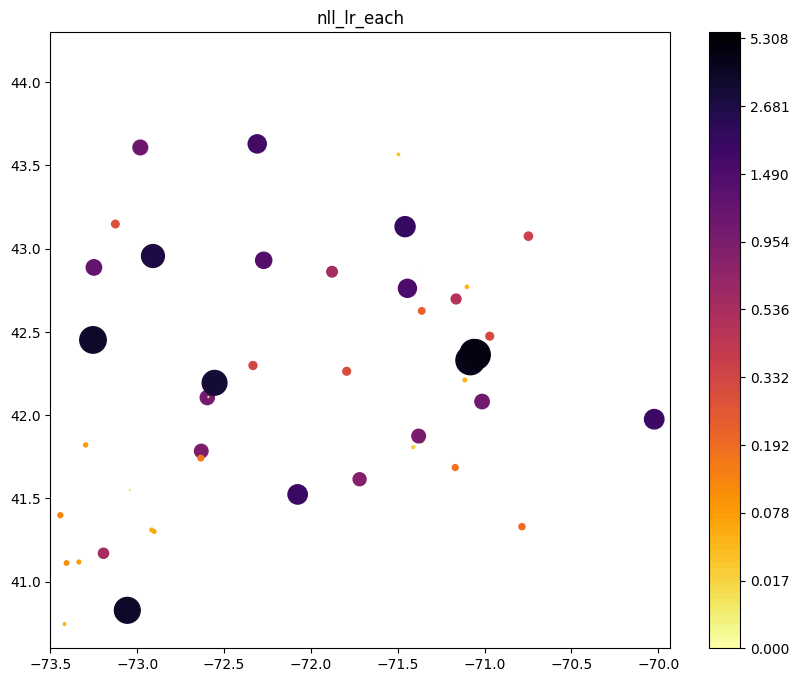

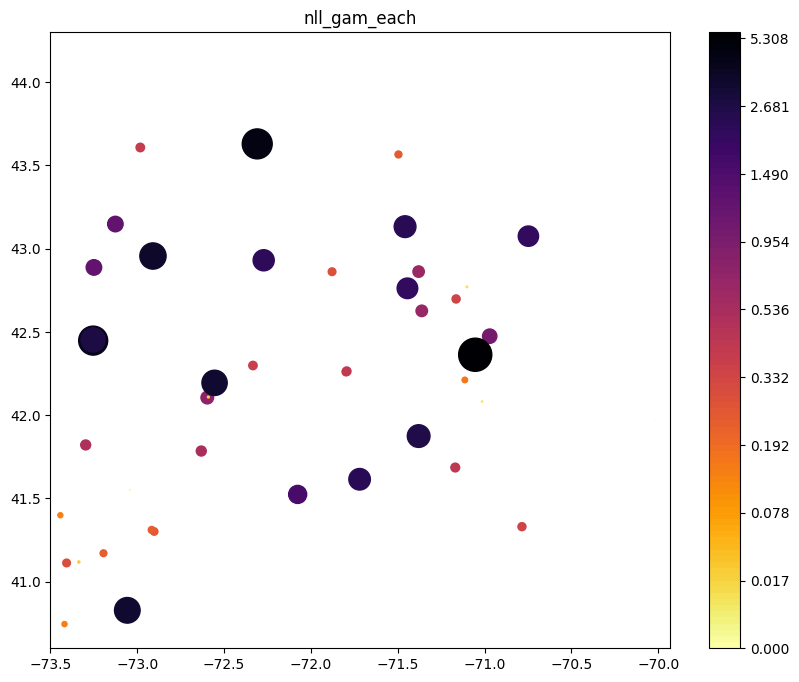

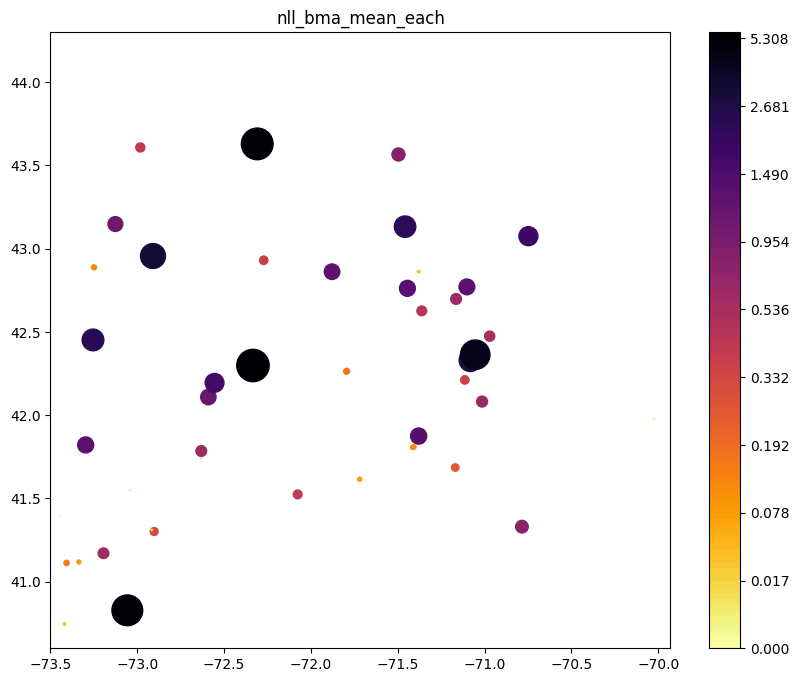

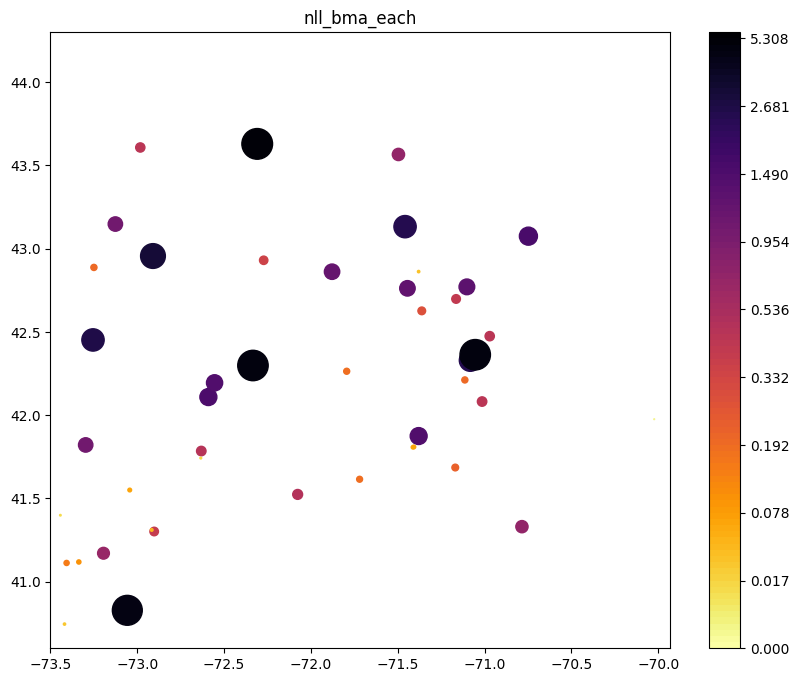

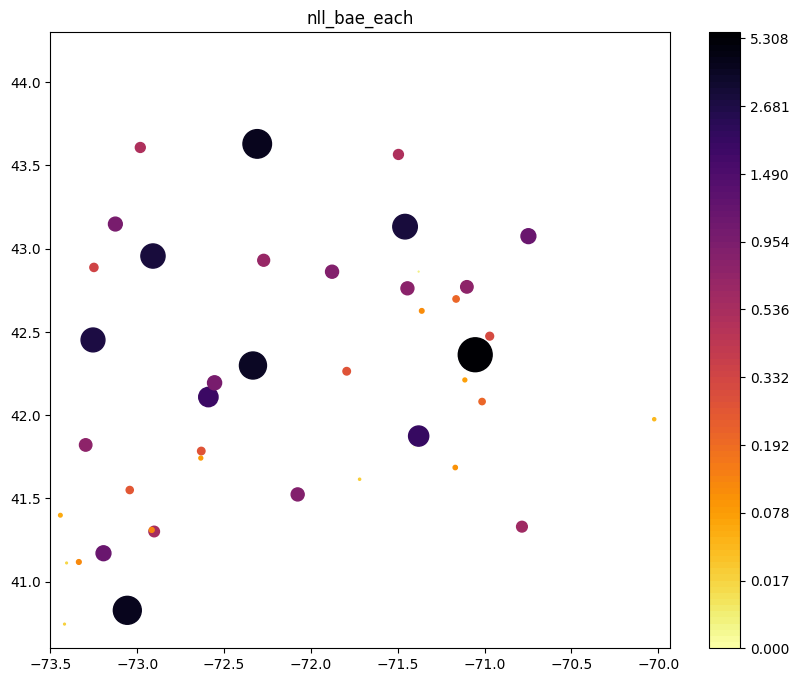

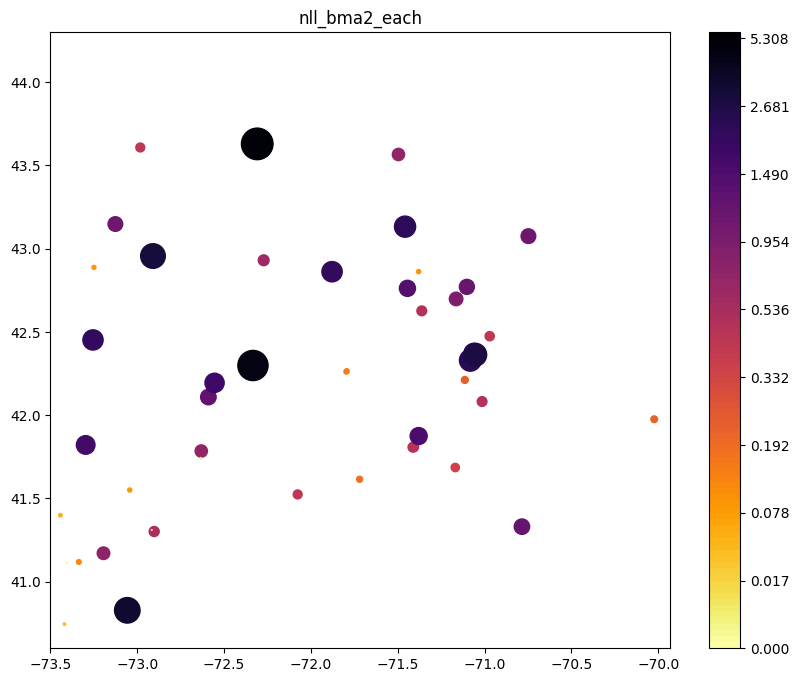

In [42]:

color_norm_nll_each = make_color_norm(
    nll_color_list.reshape(len(nll_color_list), -1),
    method='percentile')

for i in ["nll_lr_each", "nll_gam_each", "nll_bma_mean_each", "nll_bma_each", "nll_bae_each", "nll_bma2_each"]:
    # log scale colorbar
    plt.figure(figsize=(10, 8))
    plt.scatter(plt_nll["lon"], plt_nll["lat"], c=plt_nll[i], 
                s=abs(plt_nll[i])*100, cmap='inferno_r', norm=color_norm_nll_each)
    
    cbar = plt.colorbar()
    # plt.scatter(plt_nll["lon"], plt_nll["lat"], c=plt_nll[i],
    #             s=abs(plt_nll[i])*50, cmap='inferno_r', norm=color_norm_nll_each)
    

    # larger points are more error
    coordinate = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)

    # limitation x y axis from coordinate
    plt.xlim(min(coordinate[:,0]), max(coordinate[:,0]))
    plt.ylim(min(coordinate[:,1]), max(coordinate[:,1]))
    plt.title(i)
    plt.show()



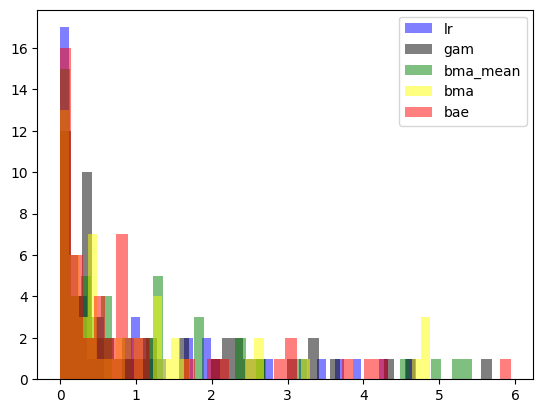

In [16]:
# use histogram to show the distribution of nll
plt.hist(nll_lr_each, bins=40, color='blue', alpha=0.5, label='lr')
plt.hist(nll_gam_each, bins=40, color='black', alpha=0.5, label='gam')
plt.hist(nll_bma_mean_each, bins=40, color='green', alpha=0.5, label='bma_mean')
plt.hist(nll_bma_each, bins=40, color='yellow', alpha=0.5, label='bma')
plt.hist(nll_bae_each, bins=40, color='red', alpha=0.5, label='bae')

plt.legend(loc='upper right')
plt.show()


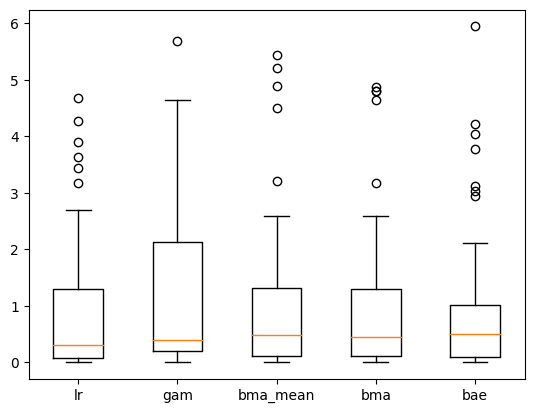

,lr,gam,bma_mean,bma,bae
0.05,0.003863,0.001740,0.006369,0.014904,0.000950
0.25,0.071080,0.197964,0.104131,0.114492,0.102158
0.5,0.310231,0.400264,0.488557,0.448680,0.508847
0.75,1.291155,2.125512,1.317591,1.303108,1.007613
0.95,3.764705,3.963713,4.697655,4.717722,3.909793


In [26]:
# use boxplot to visualize the distribution of nll for each model
plt.boxplot([nll_lr_each, nll_gam_each, nll_bma_mean_each, nll_bma_each, nll_bae_each],
            labels=['lr', 'gam', 'bma_mean', 'bma', 'bae'])
plt.show()

# table to show the mean, median and std of nll for each model

nll_lr_each_mean = np.mean(nll_lr_each)
nll_lr_each_median = np.median(nll_lr_each)
nll_lr_each_std = np.std(nll_lr_each)

nll_gam_each_mean = np.mean(nll_gam_each)
nll_gam_each_median = np.median(nll_gam_each)
nll_gam_each_std = np.std(nll_gam_each)

nll_bma_mean_each_mean = np.mean(nll_bma_mean_each)
nll_bma_mean_each_median = np.median(nll_bma_mean_each)
nll_bma_mean_each_std = np.std(nll_bma_mean_each)

nll_bma_each_mean = np.mean(nll_bma_each)
nll_bma_each_median = np.median(nll_bma_each)
nll_bma_each_std = np.std(nll_bma_each)

nll_bae_each_mean = np.mean(nll_bae_each)
nll_bae_each_median = np.median(nll_bae_each)
nll_bae_each_std = np.std(nll_bae_each)

table_nll = pd.DataFrame(
    {"lr": [nll_lr_each_mean, nll_lr_each_median, nll_lr_each_std],
        "gam": [nll_gam_each_mean, nll_gam_each_median, nll_gam_each_std],
        "bma_mean": [nll_bma_mean_each_mean, nll_bma_mean_each_median, nll_bma_mean_each_std],
        "bma": [nll_bma_each_mean, nll_bma_each_median, nll_bma_each_std],
        "bae": [nll_bae_each_mean, nll_bae_each_median, nll_bae_each_std]},
    index=["mean", "median", "std"]
)

#  quantile of nll for each model

nll_lr_each_quantile = np.quantile(nll_lr_each, [0.05, 0.25, 0.5, 0.75, 0.95])
nll_gam_each_quantile = np.quantile(nll_gam_each, [0.05, 0.25, 0.5, 0.75, 0.95])
nll_bma_mean_each_quantile = np.quantile(nll_bma_mean_each, [0.05, 0.25, 0.5, 0.75, 0.95])
nll_bma_each_quantile = np.quantile(nll_bma_each, [0.05, 0.25, 0.5, 0.75, 0.95])
nll_bae_each_quantile = np.quantile(nll_bae_each, [0.05, 0.25, 0.5, 0.75, 0.95])

table_nll_quantile = pd.DataFrame(
    {"lr": nll_lr_each_quantile,
        "gam": nll_gam_each_quantile,
        "bma_mean": nll_bma_mean_each_quantile,
        "bma": nll_bma_each_quantile,
        "bae": nll_bae_each_quantile},
    index=["0.05", "0.25", "0.5", "0.75", "0.95"]
)
table_nll_quantile
